### Cab-Driver Agent

In [2]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import tensorflow as tf
import time

# for building DQN model
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

In [3]:
print(tf.__version__)
tf.compat.v1.disable_eager_execution()

2.4.1


#### Defining Time Matrix

In [4]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

#### Tracking the state-action pairs for checking convergence


In [5]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [6]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.01
        self.epsilon_max = 1
        self.epsilon = 1
        # the epsilon decay rate has been estimated from the graph shown at the end of the file
        self.epsilon_decay = 0.9991
        #self.epsilon_decay = 0.993
        #self.epsilon_decay = 0.992
        self.epsilon_min = 0.01
        
        self.batch_size = 32        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets       
        # hidden layers
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))

        # the output layer: output is of size num_actions
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model



    def get_action(self, state,env):
    # Write your code here:
    # get action from model using epsilon-greedy policy
    # Decay in ε after we generate each sample from the environment
        #print("Get Action state is ",state)
        possible_actions_index,actions = env.requests(state) # Find possible action indexes and append 0
        possible_actions_index.append(0)
        if np.random.rand() <= self.epsilon:
            # explore: choose a random action from all possible actions
            # Give a random action only amongst possible action
            return random.sample(possible_actions_index,1)[0]
        else:
            # choose the action with the highest q(s, a)
            # the first index corresponds to the batch size, so
            # reshape state to (1, state_size) so that the first index corresponds to the batch size
            state = state.reshape(1, self.state_size)
            q_value = self.model.predict(state)
            # Give action with max q_value only amongst possible action
            return np.where(q_value[0] == np.max(np.array([q_value[0][i] for i in possible_actions_index])))[0][0]
        
        
        
        


    def append_sample(self, state, action, reward, next_state,done):
    # Write your code here:
    # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action, reward, next_state,done))
    
    
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self,env):
        
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size, self.state_size)) # write here
            update_input = np.zeros((self.batch_size, self.state_size)) # write here
            
            actions, rewards, done = [], [], []
            
            for i in range(self.batch_size):
                state, action, reward, next_state, done_boolean = mini_batch[i]
                
                update_input[i] = state
                actions.append(action)
                rewards.append(reward)
                done.append(done_boolean)
                update_output[i] = next_state
                
                # Write your code from here
                
            # 1. Predict the target from earlier model           
            target = self.model.predict(update_input)
            
            # 2. Get the target for the Q-network
            target_qval = self.model.predict(update_output)
                
                #3. Update your 'update_output' and 'update_input' batch
            for i in range(self.batch_size):
                # Find possible actions from next state
                next_possible_actions_index,_ = env.requests(update_output[i])
                next_possible_actions_index.append(0)
                if not done[i]:
                    # Only take the max q_value from valid actions from next state
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(np.array([target_qval[i][j] for j in next_possible_actions_index]))
                else:
                    target[i][actions[i]] = rewards[i]
                
                
        # 4. Fit your model and track the loss values
            #print("Training Model")
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
            #print("Model Training Model")

    def save(self, name):
        self.model.save(name)

In [7]:
Episodes = 15000

### DQN block

In [8]:
agent = DQNAgent(36,21)
rewards_per_episode, episodes = [], []

for episode in range(Episodes):

    # Write code here
    # Call the environment
    env = CabDriver()
    # Call all the initialised variables of the environment
    state_space = env.state_space
    action_space = env.action_space
    state = env.state_init
    print("Initial State is ",state)
    time = 0
    #Call the DQN agent
    terminal_state = False
    score = 0
    action = agent.get_action(env.state_encod_arch1(state),env)
    score += env.reward_func(state,action_space[action],Time_matrix)
    next_state,ride_time = env.next_state_func(state,action_space[action],Time_matrix)
    time += ride_time
    if time >= 24*30:
        agent.append_sample(env.state_encod_arch1(state),action,score,env.state_encod_arch1(next_state),True)
    else:
        agent.append_sample(env.state_encod_arch1(state),action,score,env.state_encod_arch1(next_state),False)
    loop = 0
    
    while not terminal_state:
        
        # Write your code here
        
        if time >= 24*30:
            terminal_state = True
            pass
        state = next_state
        # 1. Pick epsilon-greedy action from possible actions for the current state
        action = agent.get_action(env.state_encod_arch1(state),env)
        # 2. Evaluate your reward and next state
        reward_curr_ride = env.reward_func(state,action_space[action],Time_matrix)
        score+= reward_curr_ride
        next_state,ride_time = env.next_state_func(next_state,action_space[action],Time_matrix)
        time += ride_time
        # 3. Append the experience to the memory
        if time >= 24*30:
            agent.append_sample(env.state_encod_arch1(state),action,reward_curr_ride,env.state_encod_arch1(next_state),True)
        else:
            agent.append_sample(env.state_encod_arch1(state),action,reward_curr_ride,env.state_encod_arch1(next_state),False)
        # 4. Train the model by calling function agent.train_model
        agent.train_model(env)
        #print('Time elapsed {} and current loop {}'.format(time,loop))
        loop+= 1
        # 5. Keep a track of rewards, Q-values, loss
    
    rewards_per_episode.append(score)   
    episodes.append(episode)
    
    if agent.epsilon > agent.epsilon_min:
        agent.epsilon *= agent.epsilon_decay

    # every episode:
    print("episode {0}, reward {1}, memory_length {2}, epsilon {3}, time {4}, rides {5}".format(episode,
                                                                         score,
                                                                         len(agent.memory),
                                                                         agent.epsilon,time,loop))
    # every few episodes:
    if episode % 1000 == 0:
        # store q-values of some prespecified state-action pairs
        # q_dict = agent.store_q_values()

        # save model weights
        agent.save(name="model_weights.h5")
        

Initial State is  [3, 17, 4]


TypeError: can only concatenate list (not "tuple") to list

### Tracking Convergence

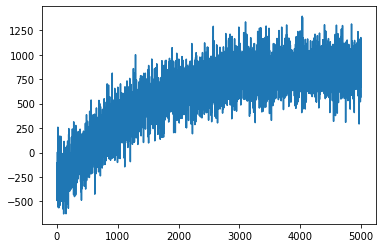

In [8]:
plt.plot(episodes,rewards_per_episode)

# It is evident from the above graph that the rewards increased and stabilised after 3000 epochs as given by the epsilon function at the end of file¶

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [9]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

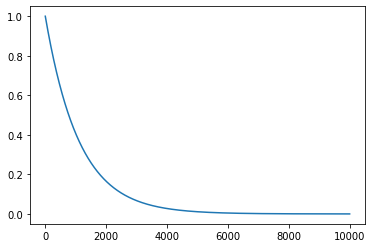

In [10]:
plt.plot(time, epsilon)
plt.show()

In [11]:
epsilon2=[]
for i in range(0,10000):
    if i==0:
        epsilon2.append(1)
    else:
        epsilon2.append(0.9991 * epsilon2[i-1])

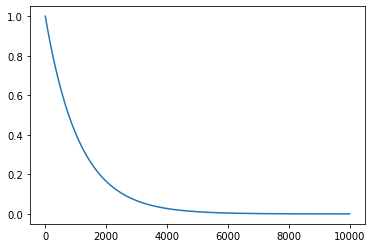

In [12]:

plt.plot(time, epsilon2)
plt.show()

# It is evident from the above graph that epsilon decays and stabilized after 3000 epochs as required by the previous epsilon decay graph. It has been used to train the model